In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
# Without this the model will doesn't compile
tf.enable_eager_execution()

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [0]:
# Load dataset
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [0]:
# Reshape the image to 28x28x1 (black and white)
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
# Normalize data between the range [-1, 1]
train_images = (train_images - 127.5) / 127.5

In [0]:
# Size of the buffer taken from the dataset to shuffle
BUFFER_SIZE = 60000
# Size of the batch we train per time
BATCH_SIZE = 256

In [0]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
def make_generator_model():
  """
  Creates the generator model

  Returns:
  model: the freshly created generator model
  """
  model = tf.keras.Sequential()

  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100, )))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7, 7, 256)))
  # Ensure the data has the right size, None is the size of the batch
  assert model.output_shape == (None, 7, 7, 256) 

  # Conv layer, since padding is set to same the ouput size is (input_h*stride, input_w*stride, number_of_filters)
  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 7, 7, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  # This last layer has the size of the output we want to generate
  model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)

  return model

In [0]:
generator = make_generator_model()

In [0]:
def make_discriminator_model():
  """
  Creates the discriminator model

  Returns:
  model: the freshly created discriminator model
  """
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
  model.add(layers.LeakyReLU())
  # Regularization
  model.add(layers.Dropout(0.3))
  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))
  model.add(layers.Flatten())
  # The output of the model is True/False, just 1 neuron
  model.add(layers.Dense(1))

  return model

In [0]:
discriminator = make_discriminator_model()

In [0]:
# Define the loss function, in this case is binaryCrossentropy since this is a binary classification problem
# It's defined outside of the functions because it's used in both models 
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(real_output, fake_output):
  """
  Defines the loss function for the discriminator

  Returns:
  total_loss: the loss function just created
  """
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  
  return total_loss

In [0]:
def generator_loss(fake_output):
  """
  Defines the loss function for the generator

  Returns:
  the loss function just created
  """
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
# Defines the optimizers for each model
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [0]:
# We use checkpoint in order to save the steps made while training in case of a failure
# of the system while processing
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [0]:
EPOCHS = 50
# Dimension of the input noise for the generator
noise_dim = 100
num_examples_to_generate = 10


seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
  """
  Defines each step of the training step
  """
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    # Generate the image starting from the noise
    generated_images = generator(noise, training=True)

    # Pass the real images and the generated images to the discriminator
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    # Calculate losses
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    # Calculate gradient
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # Optimize params
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
def train(dataset, epochs):
  """
  Train the models

  Arguments:
  dataset: the dataset containing all the images
  epochs: # of iterations on the dataset
  """
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [0]:
def generate_and_save_images(model, epoch, test_input):
  """
  Generates random images and saves the charts

  Arguments:
  model: the model of the generator
  epoch: number of epoch of this images
  test_input: random seed
  """


  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

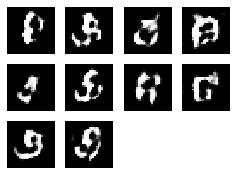

Time for epoch 18 is 773.5978791713715 sec


In [0]:
train(train_dataset, EPOCHS)